In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import warnings
import emcee
from corner import corner
from pathlib import Path
import pandas as pd

from data import dataloader
from models.model import Model
import matplotlib.pyplot as plt
from scipy import stats as st

# warnings.filterwarnings("ignore", category=RuntimeWarning, module="emcee")
warnings.filterwarnings("ignore", module="corner")
warnings.filterwarnings("ignore", category=UserWarning, module="arviz")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="arviz")
warnings.filterwarnings("ignore", module="emcee")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$ \mu(z; \Omega_{m,0}) = m_B - (M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*) + \epsilon $$

More useful for MCMC is to rewrite this in the form of "true = model + error". Note the sign for the error
term doesn't matter.

$$ m_B = [\mu(z; \Omega_{m,0}) + M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*] + \epsilon $$

In [5]:
class Results:
    
    def __init__(self, results_fpath, model=None):
        self.results_fpath = Path(results_fpath)
        self.hdf = emcee.backends.HDFBackend(str(self.results_fpath))
        self.model = model
        
        with self.hdf.open("r") as f:
            self.labels = list(f["parameter_names"].asstr())
            
        self.trace = az.from_emcee(self.hdf, var_names=self.labels)
        
    @property
    def parameter_names(self):
        return list(self.trace.posterior.data_vars.keys())
        
    def get_trace(self, burn=0):
        if burn == "auto":
            burn = self.trace.posterior.dims["draw"] // 2

        return self.trace.sel(draw=slice(burn, None))
    
    def estimate_parameters(self, estimator, burn=0):
        trace = self.get_trace(burn=burn)
        
        if estimator == "mean":
            trace_mean = trace.get("posterior").mean()
            params = {k: trace_mean.get(k).values for k in trace_mean}
        elif estimator == "hdi":
            trace_mean = az.hdi(trace.get("posterior")).mean()
            params = {k: trace_mean.get(k).values for k in trace_mean}
        else:
            raise NotImplementedError()
            
        return params
    
    def get_hr(self, data, H0=70, host_mass=None, estimator="mean", burn="auto"):
        from models.distmod_cosmology import get_mu_th
        params = self.estimate_parameters(estimator, burn=burn)
        
        mu_th = get_mu_th(H0, params["Om0"], data["redshift"])
        
        mu_pred = self.model.predict_mu(data["mag"], data["stretch"], data["color"], params, host_mass)
        return mu_pred - mu_th
        
    def plot_hubble_residuals(self, x, data, estimator="mean", burn="auto", ax=None, **kwargs):
        """
        x : np.array
            Values to plot on x-axis
        """
        hr = self.get_hr(data, **kwargs)
        params = self.estimate_parameters(estimator, burn=burn)

        # Plot scatter
        ax = ax or plt.axes()
        ax.scatter(x, hr, c="k", alpha=0.33)
        
        # Plot binned means
        bins = np.linspace(np.min(x), np.max(x), 11)
        n, _ = np.histogram(x, bins)
        sum_hr, _ = np.histogram(x, bins, weights=hr)
        mean_hr = sum_hr / n

        bins_midpoint = (bins[:-1] + bins[1:])/2
        ax.scatter(bins_midpoint, mean_hr, marker="s", s=100, c="k", edgecolor="w")

        loc = params["loc"]
        meanx, meany = np.mean(x[x < loc]), np.mean(hr[x < loc])
        ax.hlines(meany, 0, loc, color="r")
        ax.scatter(meanx, meany, color="r", s=50, marker="s", edgecolors="k")

        meanx, meany = np.mean(x[x >= loc]), np.mean(hr[x >= loc])
        ax.hlines(meany, loc, 20, color="r")
        ax.scatter(meanx, meany, color="r", s=50, marker="s", edgecolors="k")
        
        
        # Plot mass step
        ax.axvline(params["loc"], c="k", lw=2)

        return ax

    
    def plot_trace(self):
        trace = self.get_trace()
        return az.plot_trace(trace)
  
    def plot_corner(self, burn="auto", **kwargs):
        trace = self.get_trace(burn)
        fig = corner(trace, show_titles=True, **kwargs)
        fig.subplots_adjust(hspace=0, wspace=0)

''

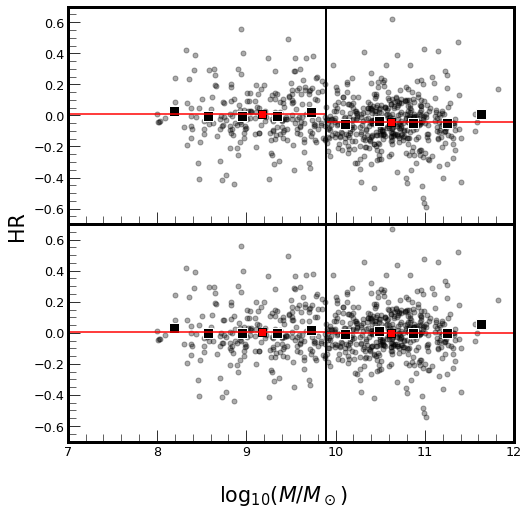

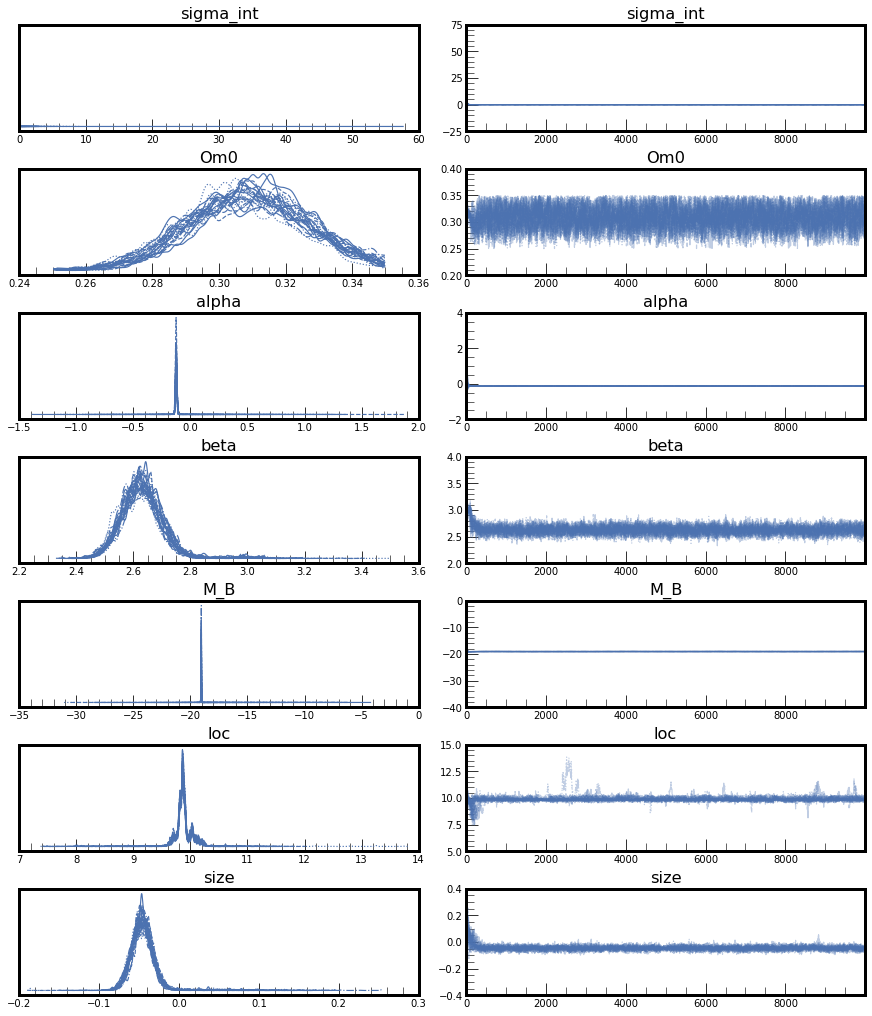

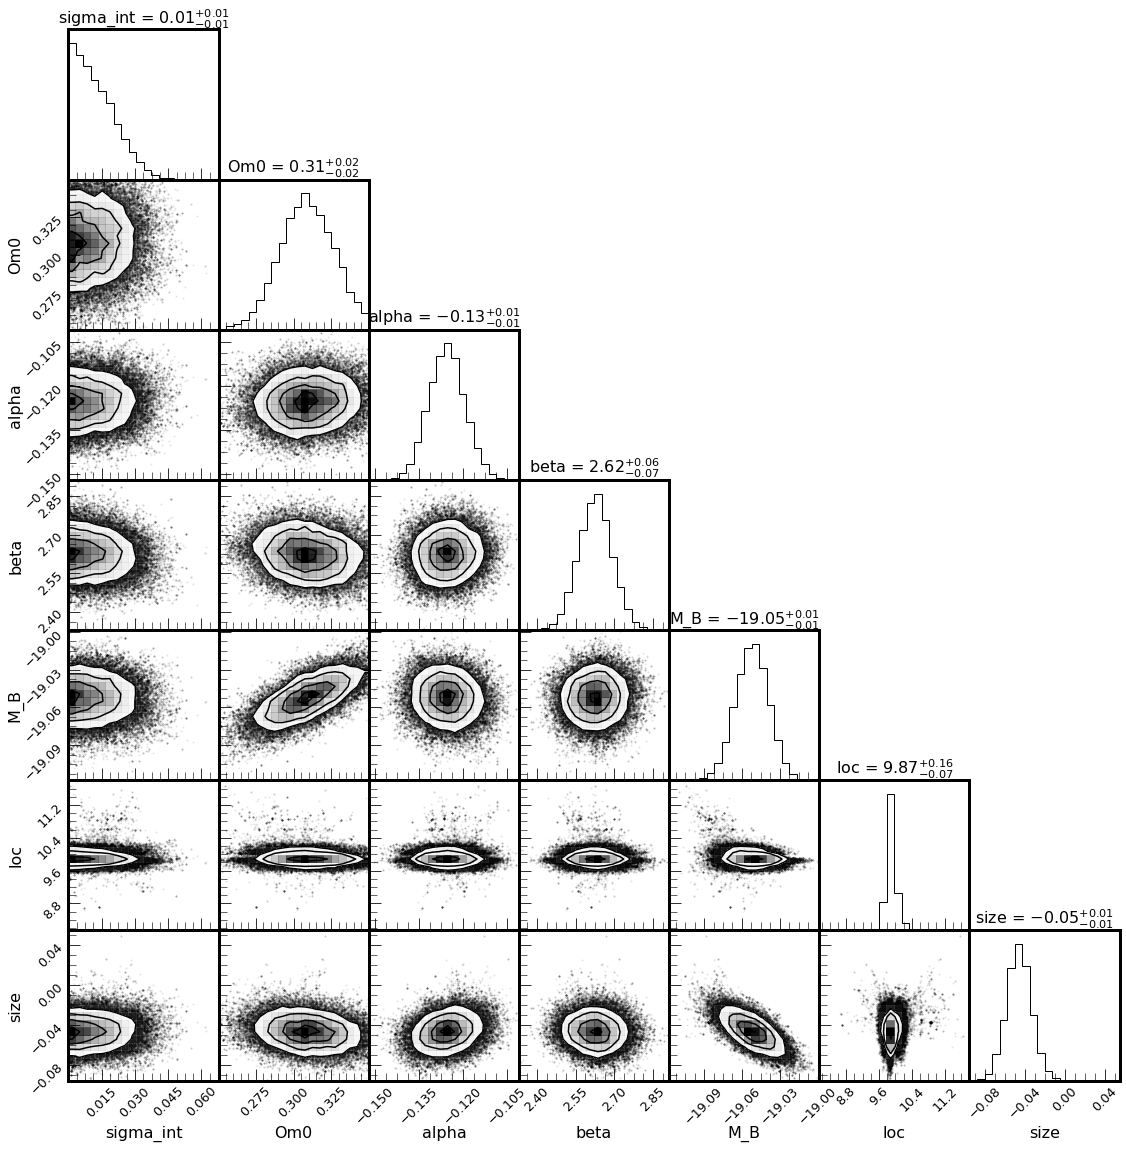

In [7]:
model = Model(
    H0=70,
    host_mass_correction_model="step"
)
r = Results("results/jla/results_2021-08-04T0723.hd5", model=model)
data = dataloader.get_jla().dropna(subset=["host_mass"]).query("host_mass>=8")

# Plot HR vs. Mass
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)
r.plot_hubble_residuals(data["host_mass"], data, burn="auto", ax=ax1)
r.plot_hubble_residuals(data["host_mass"], data, host_mass=data["host_mass"], burn="auto", ax=ax2)

fig.subplots_adjust(hspace=0, wspace=0)
fig.supxlabel("$\log_{10}(M/M_\odot)$")
fig.supylabel("HR")
for ax in (ax1, ax2):
    ax.set_xlim(7, 12)
    ax.set_ylim(-0.7, 0.7)
plt.savefig(f"figures/jla/{r.results_fpath.name}_hr.pdf");

# Plot trace
r.plot_trace()
    
# Plot corner
r.plot_corner(title_kwargs={"fontsize": 16})
plt.savefig(f"figures/jla/{r.results_fpath.name}_corner.pdf");
;

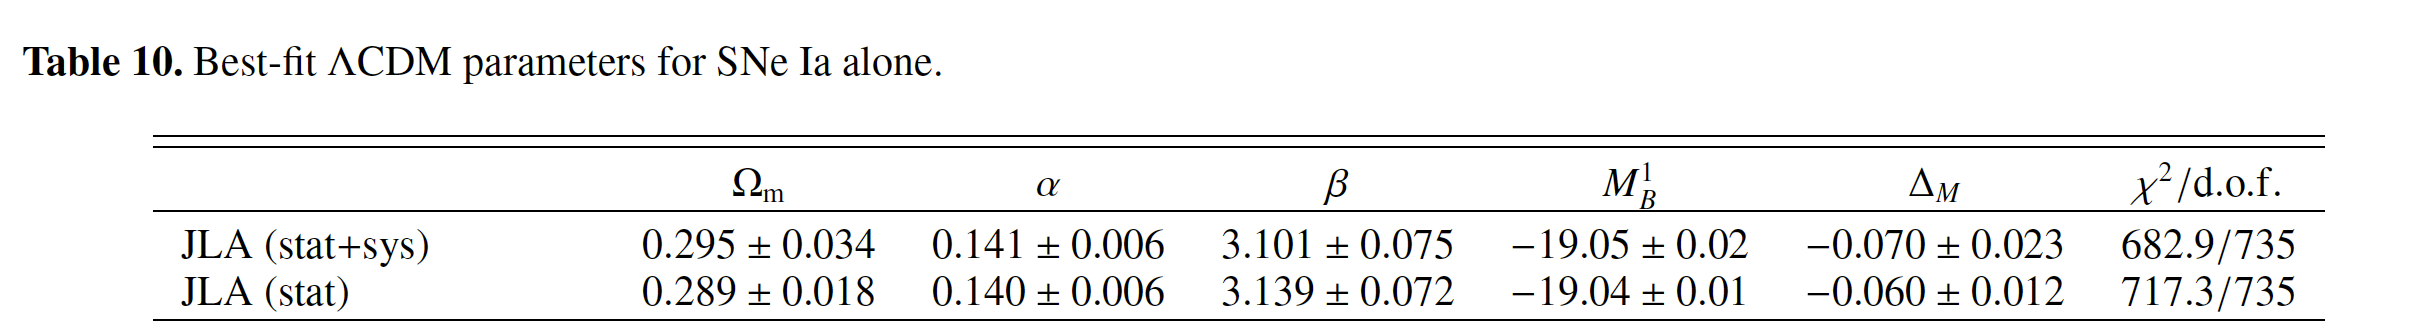

In [4]:
# rs = []
# for path in Path("results/zpeg/").glob("*.hd5"):
#     r = Results(path)
#     rs.append(r)
# rs.pop(2)

# parameter_names = rs[0].parameter_names
# file_names=[r.fpath.name for r in rs]

# for k in parameter_names:
#     az.plot_forest([r.get_trace(burn="auto") for r in rs], combined=True, var_names=k, model_names=file_names, colors="black", figsize=(12, 8))
#     plt.savefig(f"figures/zpeg/hdi_{k}.pdf")